<a href="https://colab.research.google.com/github/thespacemaker/trupart/blob/master/Roboflow_EfficientDet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the most up to date version of this notebook, please copy from this link


---



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br#scrollTo=KwDS9qqBbMQa)




# Overview

💡 Recommendation: Open this blog post on [how to train EfficientDet](https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555) to continue.

In this notebook we show an example of how to train EfficientDet using a pytorch implementation on a custom dataset that has been uploaded through RoboFlow. The example provides a flexible framework, so you can apply it to your own dataset with a custom number of classes and a different objective. We we tackle chess here. 

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data and Roboflow**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full). Roboflow also hosts many other public datasets and you can easily upload your own custom dataset for your use case, augment, and export in flexible formats. Our tutorial uses Coco Json, but you might have another format (say tfrecord). No problem! Upload your dataset and we will export it in the required format.

### **Model and Training**

For a deep dive on the EfficientDet model please see [the paper](https://arxiv.org/abs/1911.09070). For a shorter look, here is a great [blog post](https://towardsdatascience.com/efficientdet-scalable-and-efficient-object-detection-review-4472ffc34fd9)! 

We use a pytorch implementation of EfficientDet using the [image detection library](https://github.com/roboflow-ai/Monk_Object_Detection) from Tessellate-Imaging for object detection. Our implementation uses the base version of EfficientDet-d0.  We train from the EfficientNet base backbone, without using a pretrained checkpoint for the detector.

### **Inference**

We witness some fast inference on a few basic examples from our test set to see that our approach is heading in the right direction.

### **Export**

We export our model weights to google drive for future utilization.

### **Next Steps**

We will be exploring evaluation on custom RoboFlow datasets and objectives compared to yoloV3, including training time, inference time, model size, and performance. 

We will also explore comparing performance from the Coco pretrained checkpoint!

## **Stay in touch!**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out to us](roboflow.ai)! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



# Setting up our envionment

In [1]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 25.22 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.


In [2]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

     |████████████████████████████████| 352.6 MB 14 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-py3-none-any.whl size=17463 sha256=95fb0d2084ba71ea1f1bb1ff04e0a7a517281bfe94240ed04c4418745fef6d32
  Stored in directory: /root/.cache/pip/wheels/18/44/5a/c7b93703f611ae3b50820efbaf265413e6b183a56cbec6f661
Successfully built dicttoxml
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-qj8hxxwg/pycocotools_a40a24cc8b3a42638ecbcd1ef9f2f552
  Running command git clone -q https://github.com/abhi-kumar/cocoapi.git /tmp/pip-install-qj8hxxwg/pycocotools_a40a24cc8b3a42638ecbcd1ef9f2f552
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263839 sha256=9043d165cd3c28111c8571b050b3b808a57f2b768557e15e18a5602798174350
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [3]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

     / 91 kB 4.4 MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47879 sha256=304c7831a543065318e1e8cc973b92a7878baeccaceb6c31678cfd7000315a62
  Stored in directory: /tmp/pip-ephem-wheel-cache-flai23g8/wheels/b5/36/d9/593e7ac06d343d0a32138fa6c402dc3a0bd31442c9fe53f76c
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
fbprophet 0.7.1 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f27b323f155fe59c54c420255d7f404fb542fab2b0bd3c07f25c68133fde7271


# Let's get some data! 

The best part about Roboflow is the efficient management of your datasets. [Upload you dataset](roboflow.ai) and you will recieve a fresh curl code to ouput it in whatever augmented and annotated format you need. 

In [4]:
#fresh curl courtesy of roboflow.ai, outputing our dataset in Coco Json format

!curl -L "https://app.roboflow.com/ds/zJoqJlkaUO?key=AT4KT6XkJF" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/frame_1616--1-_jpg.rf.666537edf012013a44c5bd8cc87f4e6f.jpg  
 extracting: train/frame_1617--1-_jpg.rf.1342bab3bad08b92c3c66ac70d72a228.jpg  
 extracting: train/frame_1617--1-_jpg.rf.6e35c3dd5086ba381c08895aadb654b8.jpg  
 extracting: train/frame_1617--1-_jpg.rf.b03e48e2d59baf5718eaab477d2df187.jpg  
 extracting: train/frame_1619--1-_jpg.rf.2187a04cd5aa28ec14cee05a96938036.jpg  
 extracting: train/frame_1619_jpg.rf.4b0837c2f84ba0c3a1471cd4f6527acc.jpg  
 extracting: train/frame_1619_jpg.rf.86103f5ff17295e35fc34f653e747ac5.jpg  
 extracting: train/frame_1619_jpg.rf.ad61428638fa981083b6eb14386eaf70.jpg  
 extracting: train/frame_1619_jpg.rf.dfa718907d221e9bec43a9e7a4cc71e4.jpg  
 extracting: train/frame_1620_jpg.rf.1be00235498d97433d6872eff53f4c68.jpg  
 extracting: train/frame_1621--1-_jpg.rf.2129dc3ca317304839b8b1e15f3a0f35.jpg  
 extracting: train/frame_1621--1-_jpg.rf.8d92acc92499af340a1de729ad457c9a.jpg  
 extracti

In [6]:
#let's take a look at our directory
#notice the data came down in train, valid, test, splits - this is pre set during the dataset upload process
%ls

Monk_Object_Detection/  sample_data/  train/
README.roboflow.txt     test/         valid/


In [7]:
#let's take a peak in train
#jpg images and some coco json annotations
%ls train

Streaming output truncated to the last 5000 lines.
frame_1412--1-_jpg.rf.e4a8188a498542d0562abc839c29c9dc.jpg
frame_1412--1-_jpg.rf.f8e245906baa0e7fda20b377cb826990.jpg
frame_1412_jpg.rf.7d0eb7b2a422896f6ffd9230119fd270.jpg
frame_1413_jpg.rf.30ec112e958ee0ccf18a6af2e4e42d50.jpg
frame_1413_jpg.rf.5c875251aa4c086279067b2cf651f21e.jpg
frame_1413_jpg.rf.9be2ca1d7d7aac434926e711a4bc8960.jpg
frame_1413_jpg.rf.9e386d2b757838aa270b26d37feafe02.jpg
frame_1413_jpg.rf.dcf79dfecfc0a8bf454a075ae23273a8.jpg
frame_1416_jpg.rf.281dbd21734b8709f6e65ffb5c743635.jpg
frame_1416_jpg.rf.b73c5b689e9862608976a3e4da3f45bc.jpg
frame_1416_jpg.rf.ecdd23822369bc091ad64262827e9f5d.jpg
frame_1418_jpg.rf.1d1c8fd7402bc3f7d5edd9ccbc971043.jpg
frame_1421_jpg.rf.04ed2e28671ede46fc9f8549602fc249.jpg
frame_1421_jpg.rf.7fe2b02c996229b85b0a1644dbba2a67.jpg
frame_1421_jpg.rf.a4a664eea6353efe686513d33ad0df6d.jpg
frame_1423--1-_jpg.rf.289f6aa19df9427ca3a2f4b499edc677.jpg
frame_1423--1-_jpg.rf.5ffb89e38fecf5f0eba80c020a98f982.jp

In [24]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir Chess
!mkdir Chess/annotations
!mkdir Chess/Annotations
!mkdir Chess/Images

mkdir: cannot create directory ‘Chess’: File exists
mkdir: cannot create directory ‘Chess/annotations’: File exists
mkdir: cannot create directory ‘Chess/Annotations’: File exists
mkdir: cannot create directory ‘Chess/Images’: File exists


In [9]:
%cp train/_annotations.coco.json Chess/annotations/instances_Images.json

In [11]:
%cp train/*.jpg Chess/Images/

# Training

In this section we set up the efficientDet-d0 model from backbone and train to our custom case

In [12]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [13]:
from train_detector import Detector

In [15]:
gtf = Detector();

In [16]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Chess";
img_dir = "./";
set_dir = "Images";

In [17]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
gtf.Model();

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [20]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [21]:
%%time
gtf.Train(num_epochs=100, model_output_dir="trained/");

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might caus


CPU times: user 18h 52min 36s, sys: 36min 16s, total: 19h 28min 52s
Wall time: 20h 6min 56s


# Inference

In [29]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [30]:
from infer_detector import Infer

In [31]:
gtf = Infer();

In [32]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")

In [34]:
#extract class list from our annotations
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [35]:
class_list

['PRODGL', 'face', 'gloves', 'hand']

In [36]:
%%time
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.032s)
CPU times: user 57.7 ms, sys: 9 ms, total: 66.7 ms
Wall time: 80.2 ms


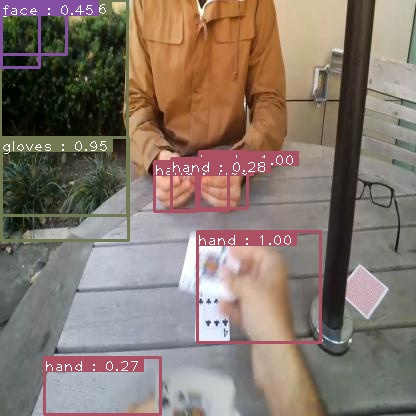

In [37]:
from IPython.display import Image
Image(filename='output.jpg') 

# Export Trained Weights

In [49]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
%mkdir trained_export
%cp ./trained/signatrix_efficientdet_coco.onnx ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).onnx
%cp ./trained/signatrix_efficientdet_coco.pth ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).pth
%mv ./trained_export/* /content/drive/My\ Drive/

# Reloading Trained Weights after Export

Imagine you have exported your trained model and would like to reaccess it later. This portion of the notebook picks up the trained model and starts at inference


In [62]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
#our fork of the Tessellate-Imaging image detection library
!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.


In [63]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-bj0yuxdi/pycocotools_0584b73360ce411ab24cdee246f69d6c
  Running command git clone -q https://github.com/abhi-kumar/cocoapi.git /tmp/pip-install-bj0yuxdi/pycocotools_0584b73360ce411ab24cdee246f69d6c
  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47879 sha256=670b7e190b9f8e957cccb8d78fd0d065871e6c575b1438ea26b2074a18d88722
  Stored in directory: /tmp/pip-ephem-wheel-cache-rus4n1e6/wheels/b5/36/d9/593e7ac06d343d0a32138fa6c402dc3a0bd31442c9fe53f76c
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, b

In [65]:
#recover trained weights
!cp '/content/drive/MyDrive/signatrix_efficientdet_coco_2021-07-22-05:02.onnx' '/trained/signatrix_efficientdet_coco.onnx'
!cp '//content/drive/MyDrive/signatrix_efficientdet_coco_2021-07-22-05:02.pth' '/trained/signatrix_efficientdet_coco.pth'

In [66]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [67]:
from infer_detector import Infer
gtf = Infer();

In [69]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="/trained")

In [71]:
#download some test data
!curl -L /content/test | jar -x

curl: (3) <url> malformed


In [ ]:
!ls test

0b47311f426ff926578c9d738d683e76_jpg.rf.0b55f43ac16aa65c889558d8ea757072.jpg
1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.9ce88078ea356949f4ab7ad9cfdfc62d.jpg
2f6fb003bb89cd401322a535acb42f65_jpg.rf.91ad9df05bd1f86bab67c8368ae5e4ad.jpg
410993714e325a1de3e394ffe860df3a_jpg.rf.519bf0fdbd5e38cd44cae1cfebc98536.jpg
4e3117459d759798537eb52cf5bf534d_jpg.rf.5b99421bf416463a8c75cfd07f8a68d1.jpg
5a35ba2ec3e0d0b2b12b1758a8ac29aa_jpg.rf.a907af85301c729635d6ab1c31eb31b2.jpg
654bb8835258b26c466b1c19893df451_jpg.rf.95aad22d4dd31ab256cb2bcff02a34dd.jpg
685b860d412b91f5d4f7f9e643b84452_jpg.rf.5ba8dc0b5d2585d01b28089debd42cd6.jpg
73a38a5c8f8f1b09f093f304660d5326_jpg.rf.2d2fa2f4b419d9f2a57fb82d38d8bc6b.jpg
749e9074a77f8d34d86e2218f26cdab4_jpg.rf.8079f8abd9f24ec16e76fcbf18489f46.jpg
7a34d8620235048917b28bcfd3b5572b_jpg.rf.71653deb6fe88ad472dabea12353373d.jpg
8ff752f9ed443e6e49d495abfceb2032_jpg.rf.c3e91277eea99c26328e39a6f0285189.jpg
a3863d0be6002c21b20ac88817b2c56f_jpg.rf.e421134b139d57e02e7df9468a35c1fb.jpg

In [72]:
#extract class list from our annotations
#in your application you will probably already have this saved
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [73]:
class_list

['PRODGL', 'face', 'gloves', 'hand']

In [ ]:
%%time
#bang!
img_path = "/content/test/c4943d83c06a12ad5e0399d19514a4ca_jpg.rf.8b0040b3b68009f6f700ea28fb1aa491.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.044s)
CPU times: user 258 ms, sys: 24.1 ms, total: 283 ms
Wall time: 279 ms


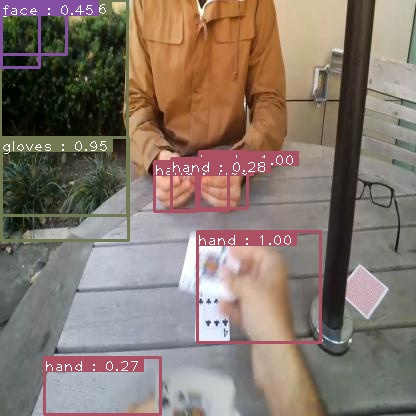

In [74]:
from IPython.display import Image
Image(filename='output.jpg') 